This notebook demonstrates item exposure distributions.

## Environment and Data

### Software Environment

We're going to start by importing the software packages we need. Python stdlib packages:


In [1]:
from pathlib import Path

PyData packages:


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

LensKit packages:


In [3]:
from lenskit import topn
from lkdemo.metrics import discount, test_weight

Local code:


In [4]:
from lkdemo.plotutils import *
from eval_tables import EvalTable
from IPython.display import HTML

Set up progress and logging output:


In [5]:
from tqdm.auto import tqdm
import logging
import lenskit.util

_log = logging.getLogger('notebook')
lenskit.util.log_to_notebook()
tqdm.pandas()

[   INFO] lenskit.util.log notebook logging configured


Where do we want output?


In [6]:
fig_dir = init_figs('ItemDists')
print(fig_dir)

using figure dir figures/ItemDists
figures/ItemDists


### Loading Data

Now let's load the MovieLens data and recommendation outputs.

First the test data:


In [7]:
test_dir = Path('data-split/ml1m/')
test = pd.read_parquet(test_dir / 'test-1.parquet')
test.head()

,user,item,rating,timestamp
index,,,,
453,6,1101,4.0,978236670
452,6,2406,5.0,978236670
509,6,1806,3.0,978236876
502,6,3699,4.0,978236567
480,6,1569,4.0,978238948


Now let's load the item data:


In [8]:
ml_dir = Path('data/ml-1m/')
movies = pd.read_table(ml_dir / 'movies.dat', sep='::', names=['item', 'title', 'genres'],
                       engine='python', encoding='latin1')
movies.set_index('item', inplace=True)
movies.head()

,title,genres
item,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


Expand that movie genre column into a matrix, allocating movies across genres:


In [9]:
genres = movies['genres'].str.split('|').explode()
genres = genres.to_frame('genre').assign(value=1)
genres = genres.pivot(columns='genre', values='value')
genres.fillna(0, inplace=True)
genres = genres.divide(genres.sum(axis=1), axis=0)
genres

genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.333333,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Quick explore - what's the total allocation to each genre?


In [10]:
genre_tot = genres.sum().to_frame('total')
genre_tot['frac'] = genre_tot['total'] / genre_tot['total'].sum()
genre_tot.sort_values('total', ascending=False)

,total,frac
genre,,
Drama,1189.066667,0.306224
Comedy,826.766667,0.212920
Thriller,264.600000,0.068143
Horror,252.016667,0.064903
Action,238.766667,0.061490
Romance,231.333333,0.059576
Sci-Fi,126.116667,0.032479
Documentary,121.500000,0.031290
Adventure,116.083333,0.029895


And the recommendations:


In [11]:
run_dir = Path('runs/')
recs = {}
for rf in run_dir.glob('ml1m-*/recs-1.parquet'):
    rdname = rf.parent.name
    algo = rdname[len('ml1m-'):]
    recs[algo] = pd.read_parquet(rf)
recs = pd.concat(recs, names=['algo'])
recs = recs.reset_index('algo').reset_index(drop=True)
recs.algo = recs.algo.astype('category').cat.rename_categories({'III': 'IKNN'})
recs.head()

,algo,item,score,user,rank
0,IKNN,1265,9.752318,6,1
1,IKNN,1196,9.746611,6,2
2,IKNN,1270,9.562931,6,3
3,IKNN,356,9.534776,6,4
4,IKNN,919,9.496835,6,5


### Computing Exposure

Now that the recommendations are computed, let's compute some per-item exposure.  Since we use the geometric browsing model,
we can get the per-item exposure simply by transforming the `rank` column:


In [12]:
recs['weight'] = discount(recs['rank'])

We can then compute the *total* exposure for each item:


In [13]:
item_exp = recs.groupby(['algo', 'item'])['weight'].mean()
item_exp.head()

algo  item
IALS  1       0.012880
      2       0.003549
      3       0.008433
      4       0.000602
      5       0.000820
Name: weight, dtype: float64

Now make it wide, fill in un-recommended items with 0 exposure, and normalize so exposure sums to 1:


In [14]:
exp_wide = item_exp.unstack('algo').reindex(movies.index).fillna(0)
exp_wide /= exp_wide.sum()
exp_wide

algo,IALS,IKNN,Pop
item,,,
1,1.601951e-03,4.309299e-03,3.979554e-03
2,4.413538e-04,3.426309e-09,7.354260e-11
3,1.048822e-03,1.944086e-28,3.547524e-18
4,7.486698e-05,1.609724e-53,5.771831e-44
5,1.019723e-04,5.931285e-20,3.027840e-23
...,...,...,...
3948,1.315921e-03,1.118933e-04,7.673705e-08
3949,2.156829e-04,6.575742e-05,5.963106e-32
3950,2.221415e-08,4.373085e-40,0.000000e+00


In [15]:
exp_wide = exp_wide[['Pop', 'IKNN', 'IALS']]

## Distribution of Exposure

Let's now look at the distribution of expoure over items!


In [16]:
exp_tall = exp_wide.melt(value_name='exposure')
exp_wide.describe()

algo,Pop,IKNN,IALS
count,3.883000e+03,3.883000e+03,3.883000e+03
mean,2.575328e-04,2.575328e-04,2.575328e-04
std,3.845030e-03,2.752246e-03,4.781942e-04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,4.298164e-21
50%,8.131271e-72,6.426970e-62,3.195034e-05
75%,8.943876e-27,4.093107e-17,3.713158e-04
max,1.162998e-01,8.748843e-02,1.137109e-02


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 3 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/ItemDists/item-exp-cdf.png
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ecdf : Removed 3260 rows containing non-finite values.


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ecdf : Removed 3260 rows containing non-finite values.


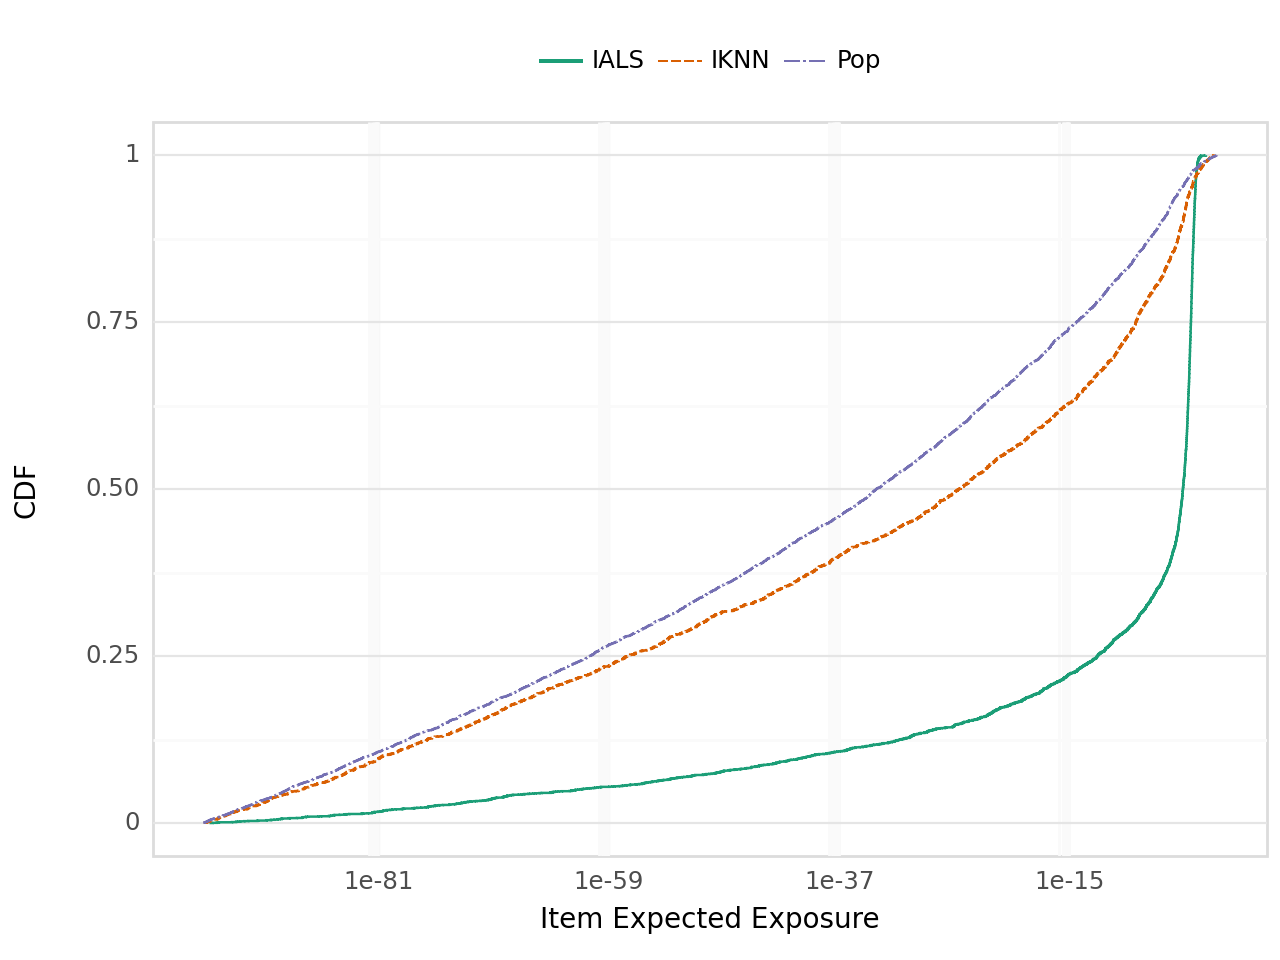

<Figure Size: (640 x 480)>

In [17]:
make_plot(
    exp_tall,
    pn.aes(x='exposure', color='algo', linetype='algo'),
    pn.stat_ecdf(),
    pn.scale_x_log10(),
    pn.scale_color_brewer('qual', 'Dark2'),
    pn.xlab('Item Expected Exposure'),
    pn.ylab('CDF'),
    legend_direction='horizontal',
    legend_position='top',
    legend_title=pn.element_blank(),
    file='item-exp-cdf.png',
    width=4.5,
    height=3,
)

[   INFO] notebook plotting Pop


[   INFO] notebook plotting IKNN


[   INFO] notebook plotting IALS


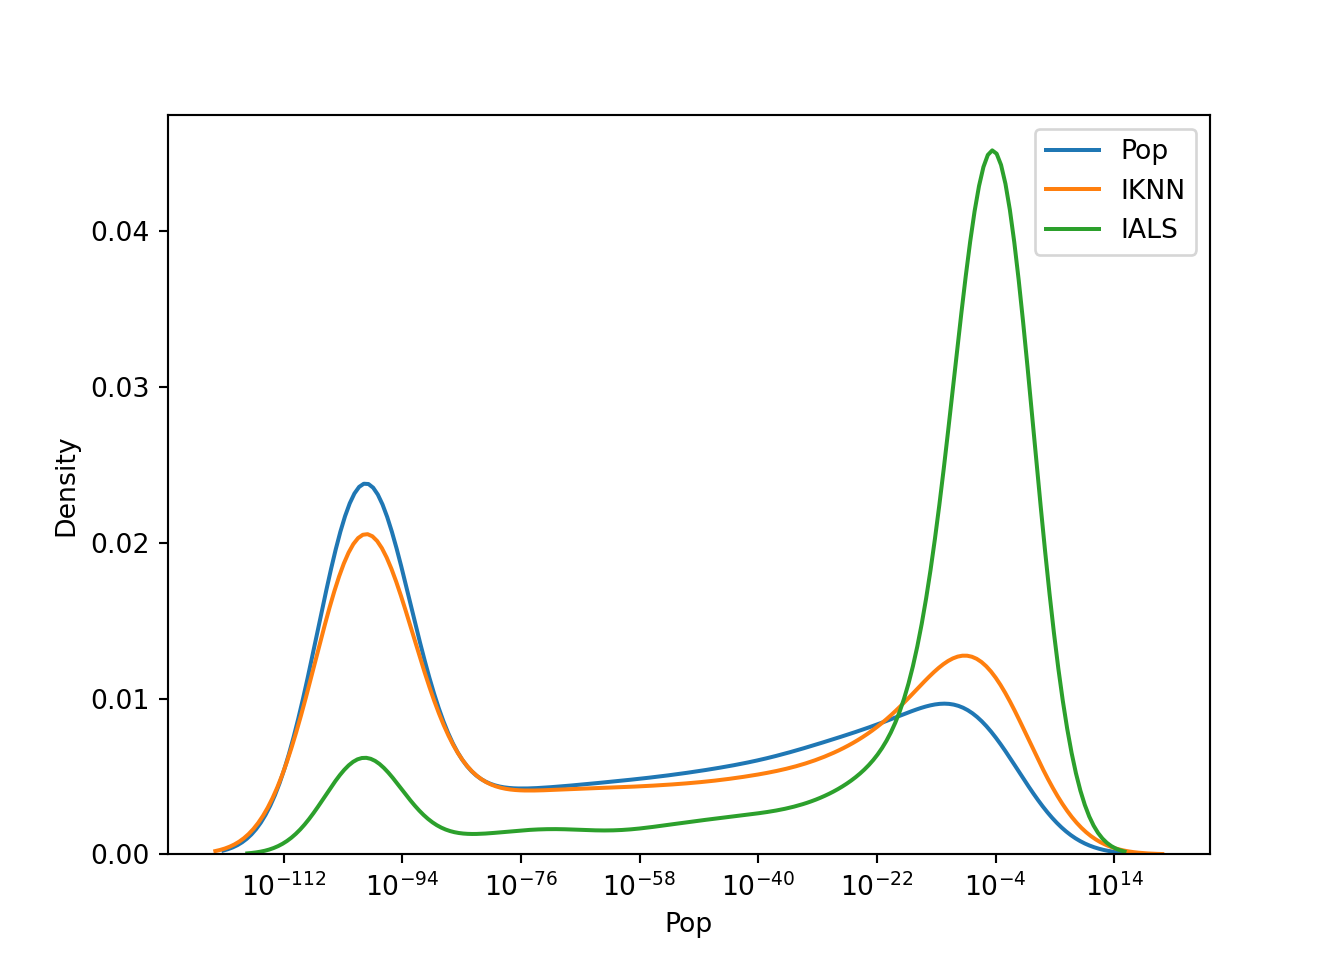

In [18]:
for name in exp_wide.columns:
    _log.info('plotting %s', name)
    sns.kdeplot(np.maximum(exp_wide[name], 1.0e-100), label=name, log_scale=True)
plt.legend()

We can conclude from this that IALS is providing more exposure to more items than both the popular and item-item algorithms.

Let's look at Lorenz curves for an alternate view.


In [19]:
exp_tall['rank'] = exp_tall.groupby('algo')['exposure'].rank(method='first')
exp_tall['frank'] = exp_tall['rank'] / exp_tall['rank'].max()
exp_tall = exp_tall.sort_values(['algo', 'rank'])
exp_tall['csum'] = exp_tall.groupby('algo')['exposure'].cumsum()
exp_tall

,algo,exposure,rank,frank,csum
7816,IALS,0.000000,1.0,0.000258,0.000000
7862,IALS,0.000000,2.0,0.000515,0.000000
7873,IALS,0.000000,3.0,0.000773,0.000000
7879,IALS,0.000000,4.0,0.001030,0.000000
7884,IALS,0.000000,5.0,0.001288,0.000000
...,...,...,...,...,...
476,Pop,0.068049,3879.0,0.998970,0.615912
1192,Pop,0.075844,3880.0,0.999227,0.691756
1178,Pop,0.087862,3881.0,0.999485,0.779618
257,Pop,0.104082,3882.0,0.999742,0.883700


Compute some Gini coefficients:


In [20]:
def exp_gini(df):
    ranks = df['rank'].max() + 1 - df['rank']
    terms = ranks * df['exposure']
    mean = df['exposure'].mean()
    N = len(df)
    G = np.sum(terms)
    G *= -2 / (N * (N - 1) * mean)
    G += (N + 1) / (N - 1)
    return G

In [21]:
algo_gini = exp_tall.groupby('algo').apply(exp_gini)
algo_gini

algo
IALS    0.732345
IKNN    0.988025
Pop     0.995073
dtype: float64

And plot Lorenz curves:


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 2 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/ItemDists/item-exp-lorenz.png


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


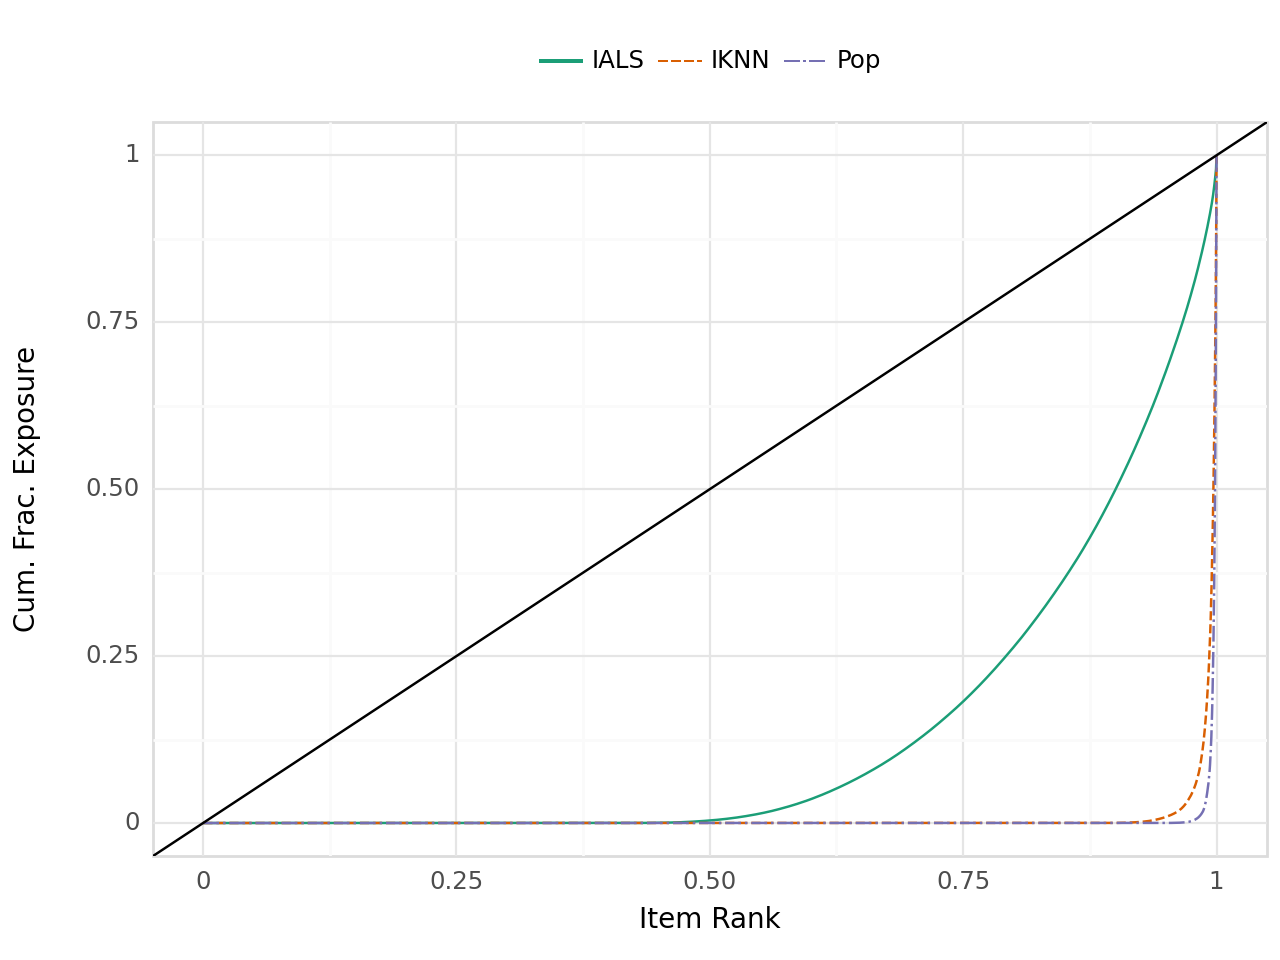

<Figure Size: (640 x 480)>

In [22]:
make_plot(
    exp_tall,
    pn.aes(x='frank', y='csum', color='algo', linetype='algo'),
    pn.geom_line(),
    pn.geom_abline(pn.aes(intercept=0, slope=1)),
    pn.scale_color_brewer('qual', 'Dark2'),
    pn.xlab('Item Rank'),
    pn.ylab('Cum. Frac. Exposure'),
    legend_direction='horizontal',
    legend_position='top',
    legend_title=pn.element_blank(),
    file='item-exp-lorenz.png',
    width=4.5,
    height=2,
)

## Group Exposure

For demonstration purposes, we're going to look at the distribution of exposure over genres.


In [23]:
genre_exp = genres.T @ exp_wide
genre_exp

algo,Pop,IKNN,IALS
genre,,,
Action,1.756758e-01,0.216734,0.089754
Adventure,1.106168e-01,0.110424,0.037990
Animation,3.276874e-03,0.002879,0.017121
Children's,6.050285e-03,0.005511,0.025301
Comedy,1.297002e-01,0.091708,0.207355
Crime,1.814326e-02,0.038697,0.028922
Documentary,1.747444e-08,0.000082,0.009275
Drama,1.613940e-01,0.108682,0.238997
Fantasy,3.084722e-02,0.023600,0.010273


In [24]:
genre_relexp = genre_exp.subtract(genre_tot['frac'], axis=0)
genre_relexp

algo,Pop,IKNN,IALS
genre,,,
Action,0.114186,0.155244,0.028264
Adventure,0.080722,0.080529,0.008095
Animation,-0.007570,-0.007967,0.006274
Children's,-0.021201,-0.021740,-0.001950
Comedy,-0.083219,-0.121211,-0.005564
Crime,-0.008112,0.012441,0.002666
Documentary,-0.031290,-0.031208,-0.022015
Drama,-0.144830,-0.197541,-0.067227
Fantasy,0.024825,0.017578,0.004251


In [25]:
genre_etall = genre_exp.reset_index().melt(id_vars='genre', value_name='exposure')
genre_rtall = genre_relexp.reset_index().melt(id_vars='genre', value_name='exposure')

Exposure per genre:


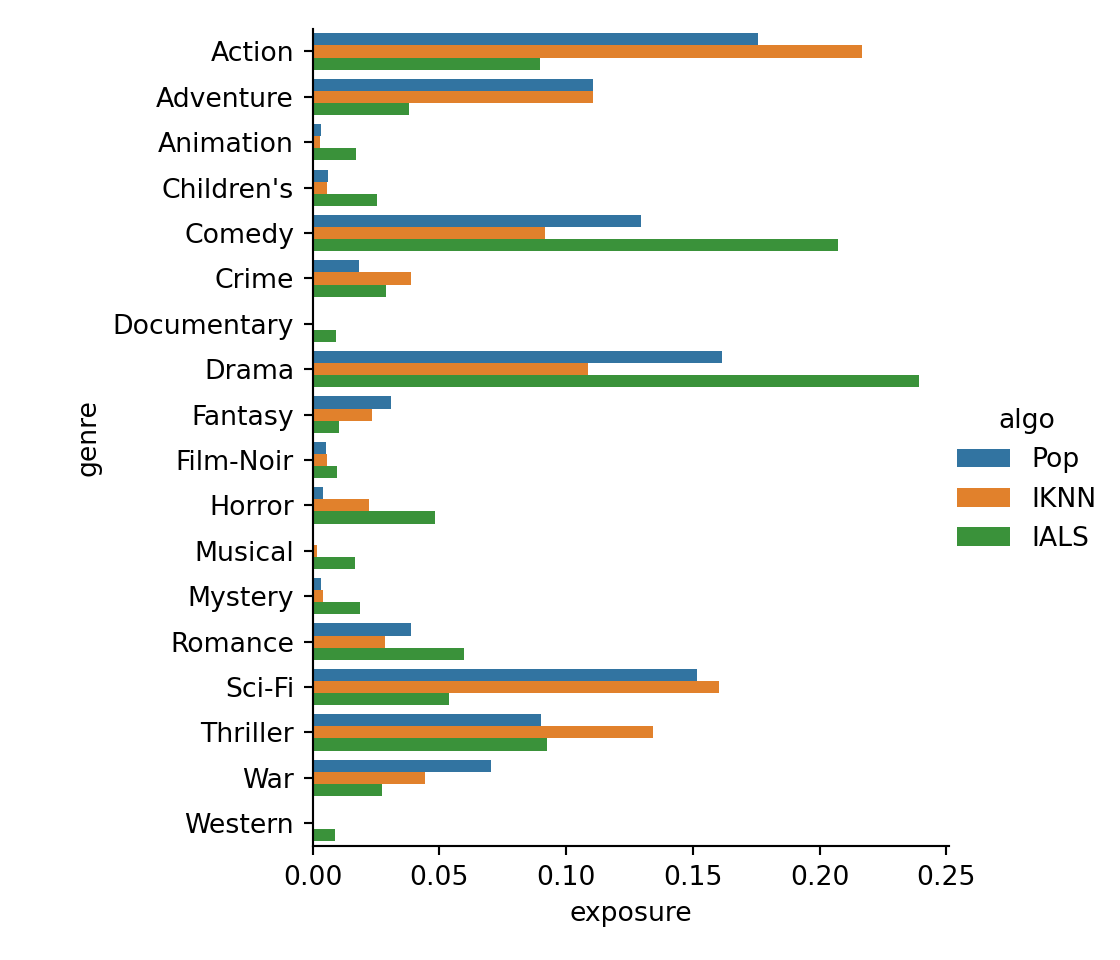

In [26]:
sns.catplot(genre_etall, y='genre', hue='algo', x='exposure', kind='bar')

Exposure relative to total per genre:


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 5 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/ItemDists/genre-exp-overall.png


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


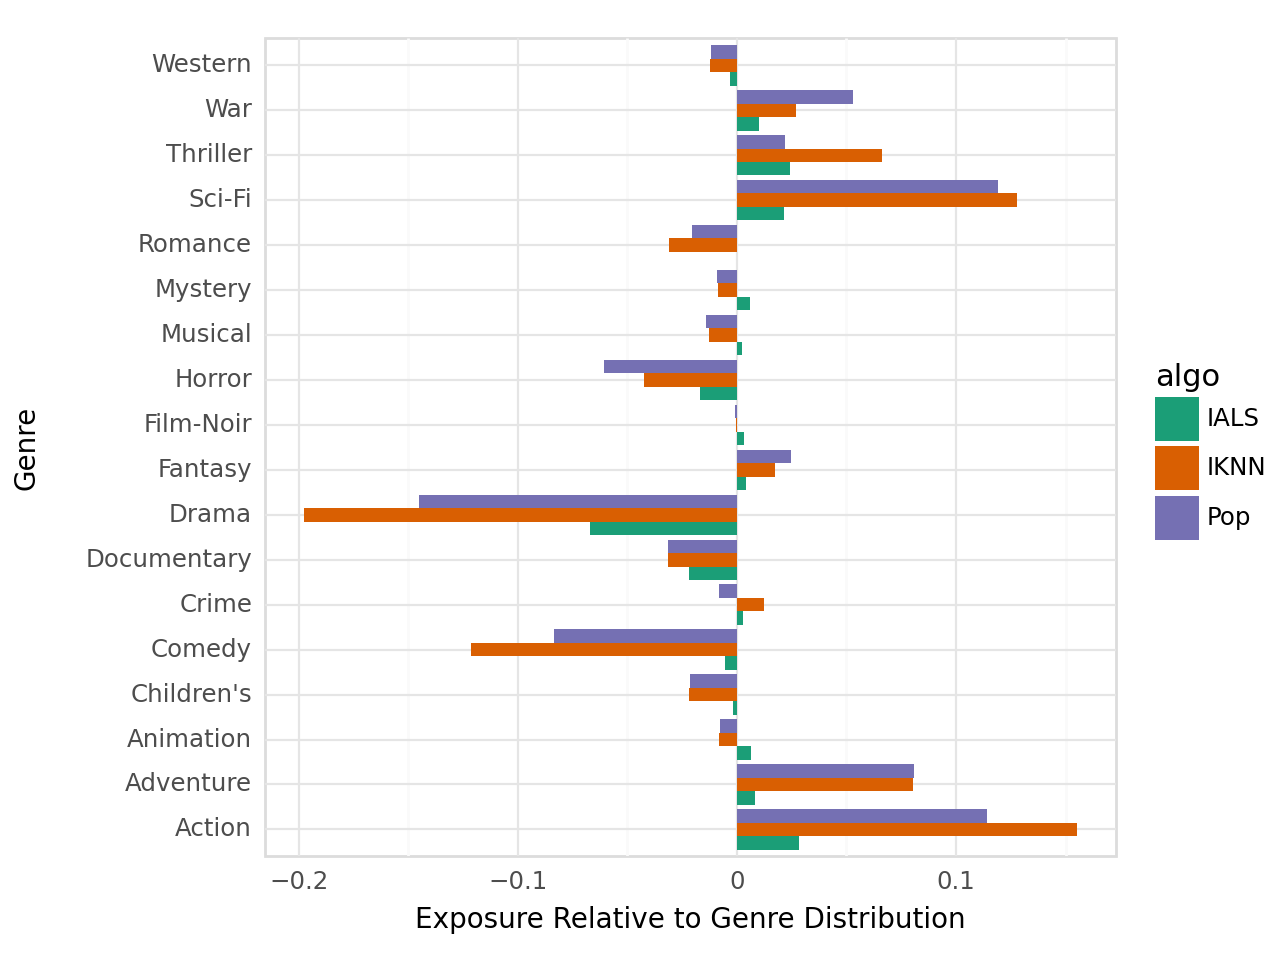

<Figure Size: (640 x 480)>

In [27]:
make_plot(
    genre_rtall,
    pn.aes(x='genre', y='exposure', fill='algo'),
    pn.geom_bar(position='dodge', stat='identity'),
    pn.coord_flip(),
    pn.scale_fill_brewer('qual', 'Dark2'),
    pn.ylab('Exposure Relative to Genre Distribution'),
    pn.xlab('Genre'),
    file='genre-exp-overall.png',
)

IALS is also doing the best at matching exposure visually; let's check that by computing the K-L divergence from overall:


In [28]:
genre_exp.apply(lambda x: stats.entropy(x, genre_tot['frac']))

algo
Pop     0.513182
IKNN    0.596517
IALS    0.045749
dtype: float64

Yes, we confirm a good match.

## Relative to Ideal

In the Expected Exposure paper, the authors define a target based on system relevance.  Let's use the test data to determine those ideals, and measure closeness.

Each user is supposed to have exactly 5 test items:


In [29]:
test.value_counts('user').describe()

count    1500.0
mean        5.0
std         0.0
min         5.0
25%         5.0
50%         5.0
75%         5.0
max         5.0
dtype: float64

We can go through the formula from Diaz et al. to determine the expected exposure of a test item given that each user has 5 relevant items.  We can also compute the total exposure in a list:


In [30]:
ltot = discount(np.arange(1, 1001)).sum()
ltot

4.000000000000001

The total for relevant items:


In [31]:
rtot = test_weight(5) * 5
rtot

3.3616

So we'll allocate 3.36/4 exposure across the relevant items equally, and 0.64/4 across the irrelevant items equally.


In [32]:
ritot = rtot / 5 / ltot
ritot

0.16807999999999998

In [33]:
nitems = len(movies)
uitot = (ltot - rtot) / ltot / (nitems - 5)
uitot

4.115523465703975e-05

In [34]:
nusers = test['user'].nunique()

  To compute the exposure expected for each item, we will start by computing the relevant item exposure, and then we will add in the estimated irrelevant item exposure based on the total item count.


In [35]:
item_tgt = test.groupby('item')['user'].count().to_frame('count')
item_tgt = item_tgt.reindex(movies.index).fillna(0)
item_tgt['rel'] = (item_tgt['count'] * ritot) / nusers
item_tgt['unrel'] = ((nusers - item_tgt['count']) * uitot) / nusers
item_tgt['exp'] = item_tgt['rel'] + item_tgt['unrel']
item_tgt

,count,rel,unrel,exp
item,,,,
1,14.0,0.001569,0.000041,0.001610
2,8.0,0.000896,0.000041,0.000937
3,5.0,0.000560,0.000041,0.000601
4,0.0,0.000000,0.000041,0.000041
5,2.0,0.000224,0.000041,0.000265
...,...,...,...,...
3948,8.0,0.000896,0.000041,0.000937
3949,2.0,0.000224,0.000041,0.000265
3950,1.0,0.000112,0.000041,0.000153


In [36]:
item_tgt.sum()

count    7500.0000
rel         0.8404
unrel       0.1596
exp         1.0000
dtype: float64

That gives us total ideal EE of 1, which is what we would expect.

Now, let's look at how this compares to the system exposure.


In [37]:
diff_wide = exp_wide.subtract(item_tgt['exp'], axis=0)
diff_wide

algo,Pop,IKNN,IALS
item,,,
1,0.002370,0.002700,-0.000008
2,-0.000937,-0.000937,-0.000496
3,-0.000601,-0.000601,0.000448
4,-0.000041,-0.000041,0.000034
5,-0.000265,-0.000265,-0.000163
...,...,...,...
3948,-0.000937,-0.000825,0.000379
3949,-0.000265,-0.000199,-0.000050
3950,-0.000153,-0.000153,-0.000153


In [38]:
diff_wide.describe()

algo,Pop,IKNN,IALS
count,3.883000e+03,3.883000e+03,3.883000e+03
mean,-3.431027e-19,-1.715513e-19,-1.054326e-19
std,3.633288e-03,2.554198e-03,2.911047e-04
min,-2.050436e-03,-2.428038e-03,-1.933441e-03
25%,-2.652070e-04,-2.652070e-04,-6.142655e-05
50%,-4.115523e-05,-4.115523e-05,-4.115523e-05
75%,-4.115523e-05,-4.115523e-05,4.953235e-05
max,1.089770e-01,8.296624e-02,5.830882e-03


In [39]:
diff_tall = diff_wide.melt()
diff_tall

,algo,value
0,Pop,0.002370
1,Pop,-0.000937
2,Pop,-0.000601
3,Pop,-0.000041
4,Pop,-0.000265
...,...,...
11644,IALS,0.000379
11645,IALS,-0.000050
11646,IALS,-0.000153
11647,IALS,-0.000153


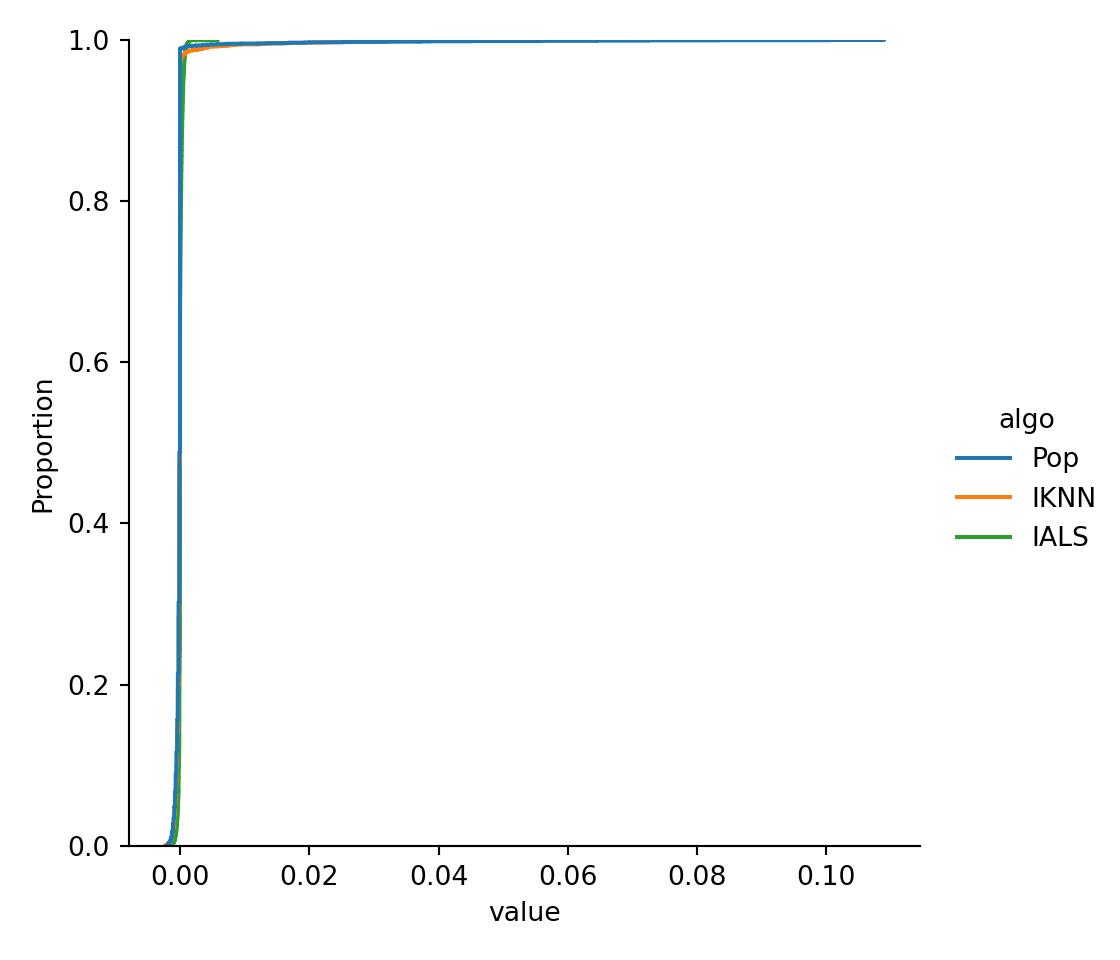

In [40]:
sns.displot(diff_tall, x='value', hue='algo', kind='ecdf')

[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 5 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/ItemDists/item-exp-ideal.png


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


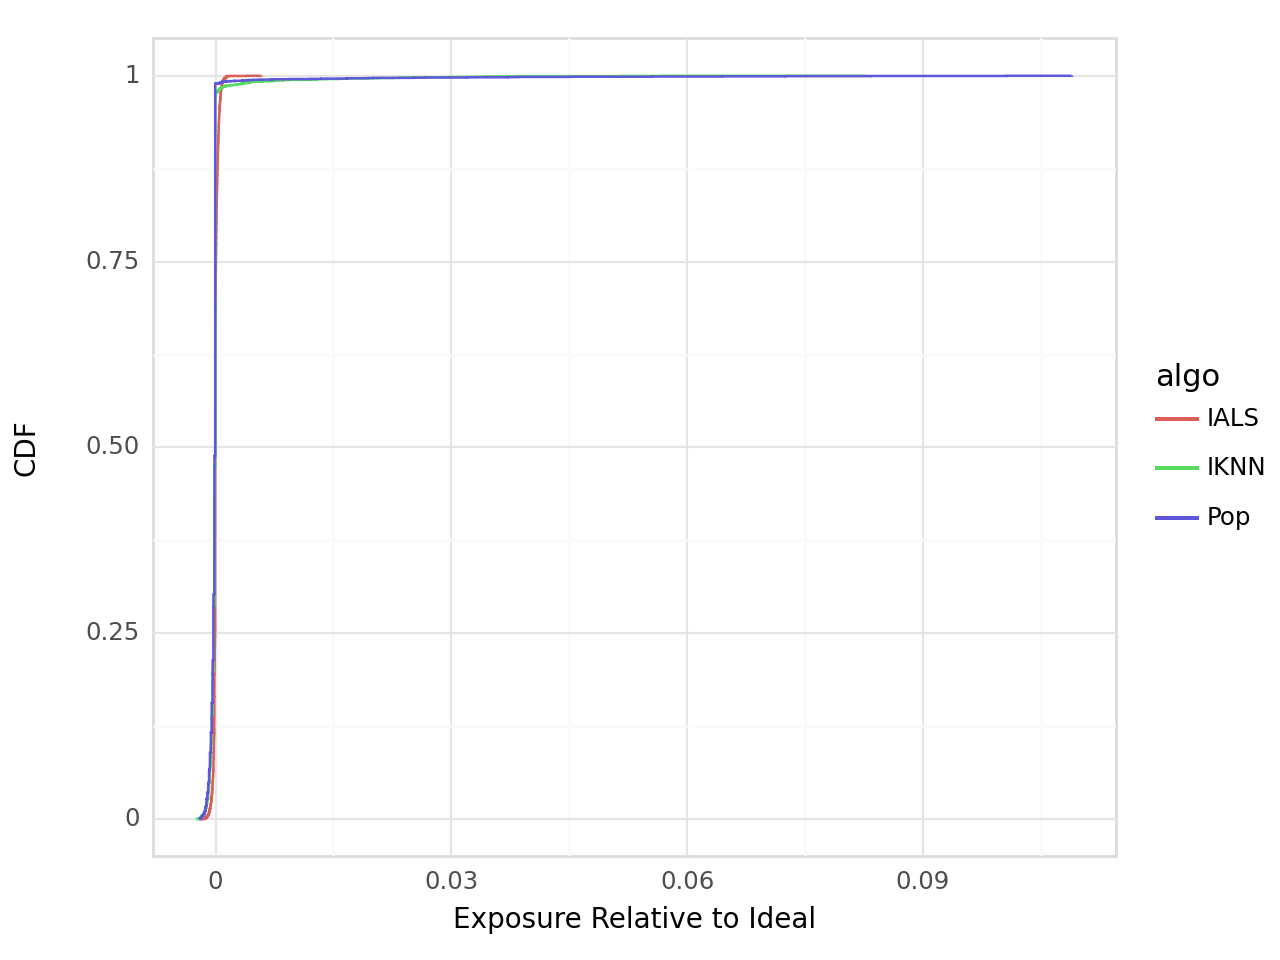

<Figure Size: (640 x 480)>

In [41]:
make_plot(
    diff_tall,
    pn.aes(x='value', color='algo'),
    pn.stat_ecdf(),
#     pn.scale_x_log10(),
    pn.ylab('CDF'),
    pn.xlab('Exposure Relative to Ideal'),
    file='item-exp-ideal.png',
)

That's hard to read.  Let's compute the EEL L2 loss function:


In [42]:
exp_l2 = np.square(diff_wide).sum()
exp_l2

algo
Pop     0.051245
IKNN    0.025326
IALS    0.000329
dtype: float64

IALS has much lower EEL.  Let's also do K-L divergence for consistency:


In [43]:
exp_kl = exp_wide.apply(lambda x: stats.entropy(x, item_tgt['exp']))
exp_kl

algo
Pop     2.398029
IKNN    1.993307
IALS    0.424431
dtype: float64

Now we're going to make a little table that has these and the Gini coefficients.


In [44]:
id_tbl = pd.DataFrame({
    'Gini': algo_gini,
    'L2': exp_l2,
    'KL': exp_kl,
})
id_tbl

,Gini,L2,KL
algo,,,
IALS,0.732345,0.000329,0.424431
IKNN,0.988025,0.025326,1.993307
Pop,0.995073,0.051245,2.398029


In [45]:
(fig_dir / 'item-dist-tbl.tex').write_text(
    id_tbl.to_latex(index_names=False)
)

/tmp/ipykernel_772772/1345269710.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


240

### Ideal Genre Exposure 

Now let's look at genres relative to targets:


In [46]:
gtgt = genres.T @ item_tgt['exp']

In [47]:
genre_diff = genre_exp.subtract(gtgt, axis=0)
genre_diff

algo,Pop,IKNN,IALS
genre,,,
Action,0.083803,0.124862,-0.002118
Adventure,0.069847,0.069655,-0.002779
Animation,-0.011769,-0.012166,0.002075
Children's,-0.017625,-0.018164,0.001626
Comedy,-0.085843,-0.123835,-0.008188
Crime,-0.011792,0.008761,-0.001014
Documentary,-0.012114,-0.012032,-0.002839
Drama,-0.072842,-0.125554,0.004760
Fantasy,0.020951,0.013704,0.000377


In [48]:
genre_diff.describe()

algo,Pop,IKNN,IALS
count,1.800000e+01,1.800000e+01,1.800000e+01
mean,-7.440036e-17,-4.105512e-17,-2.669547e-17
std,4.856790e-02,6.343227e-02,3.157419e-03
min,-8.584298e-02,-1.255542e-01,-8.187862e-03
25%,-1.673695e-02,-1.680859e-02,-2.090645e-03
50%,-1.178060e-02,-1.134170e-02,2.926868e-04
75%,1.638255e-02,1.769583e-02,2.027429e-03
max,9.731243e-02,1.248618e-01,5.015041e-03


In [49]:
genre_dtall = genre_diff.reset_index().melt(id_vars='genre')
genre_dtall

,genre,algo,value
0,Action,Pop,0.083803
1,Adventure,Pop,0.069847
2,Animation,Pop,-0.011769
3,Children's,Pop,-0.017625
4,Comedy,Pop,-0.085843
5,Crime,Pop,-0.011792
6,Documentary,Pop,-0.012114
7,Drama,Pop,-0.072842
8,Fantasy,Pop,0.020951
9,Film-Noir,Pop,-0.004128


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 5 in image.
/home/MICHAELEKSTRAND/mambaforge/envs/tors-dists/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/ItemDists/genre-exp-ideal.png


[   INFO] matplotlib.font_manager Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


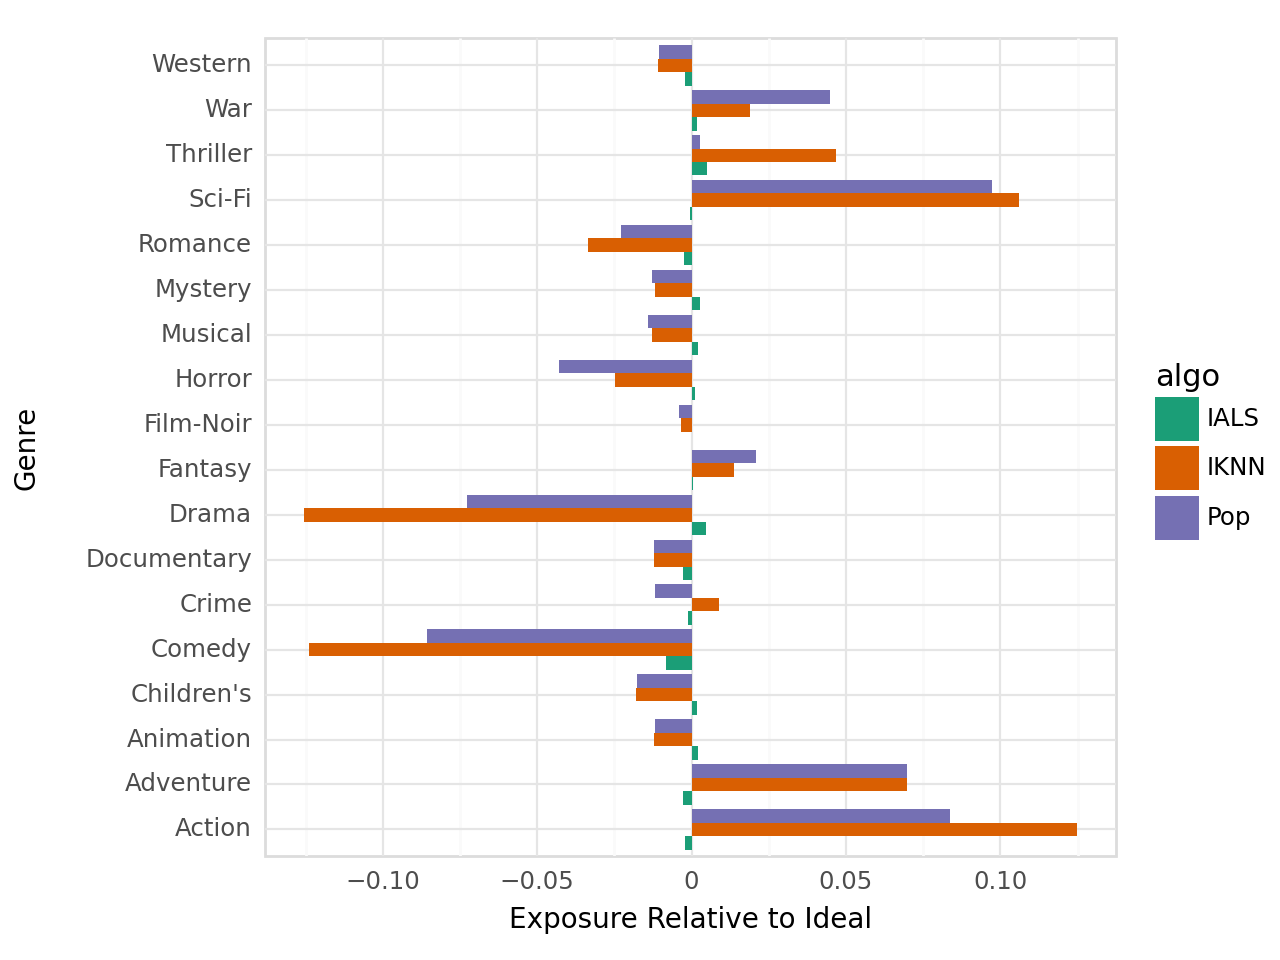

<Figure Size: (640 x 480)>

In [50]:
make_plot(
    genre_dtall,
    pn.aes(x='genre', y='value', fill='algo'),
    pn.geom_bar(position='dodge', stat='identity'),
    pn.coord_flip(),
    pn.scale_fill_brewer('qual', 'Dark2'),
    pn.ylab('Exposure Relative to Ideal'),
    pn.xlab('Genre'),
    file='genre-exp-ideal.png',
)

What's the genre-based L2 diffs?


In [51]:
np.square(genre_diff).sum()

algo
Pop     0.040100
IKNN    0.068402
IALS    0.000169
dtype: float64

And the genre-based K-L:


In [52]:
genre_exp.apply(lambda x: stats.entropy(x, gtgt))

algo
Pop     0.301985
IKNN    0.356300
IALS    0.001739
dtype: float64

Good across the board.